# 一、线性回归概念


## 1.1 模型

假设条件：自变量x和变量y存在线性关系，并且允许存在正常的噪声，例如服从正态分布的噪声  
预测模型：对于特征集合$\mathbf{X}$和预测值$\hat{y}$：$$ \hat{y} =  \mathbf{X}\mathbf{w} + b. $$ 其中的求和将使用广播机制  
目标；给定训练数据集特征$\mathbf{X}$和对应易已知的标签y，$\textbf{找到}$一组权向量$\mathbf{w}$和偏置量b。
结果：给定和$\mathbf{X}$同分布取出的新样本特征标签误差尽可能小。

## 1.2 损失函数（loss function）

选用平方误差函数：$$l(x,y) = \frac{1}{2}\left(y-\hat{y}\right)^2$$也就是在训练模型时，我们希望寻找$(\mathbf{w}^*, b^*)$最小化总损失：$$\mathbf{w}^*, b^* = \arg \min_{\mathbf{w},b} L(\mathbf{w},b) $$

# 1.3 随机梯度下降（SGD）

我们用下面的数学公式来表示这一更新过程（$\partial$表示偏导数）：

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

总结一下，算法的步骤如下：  
（1）初始化模型参数的值，如随机初始化；  
（2）从数据集中随机抽取小批量样本且在负梯度的方向上更新参数，并不断迭代这一步骤。
对于平方损失和仿射变换，我们可以明确地写成如下形式:

$$\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$

# 二、线性回归从零实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 2.1生成数据集
为了简洁，我们构造带噪声的线性数据集。

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  #标准正态分布N(0,1)
    y = torch.matmul(X, w) + b                      #matmul()实现矩阵乘法
    y += torch.normal(0, 0.01, y.shape)             #添加高斯噪声
    return X, y.reshape((-1, 1))

In [3]:
# w = [2, -3.4]^T b = 4.2 和噪声e 生成数据集和标签
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features: ',features[0], '\n labels: ', labels[0] ) #一个二维样本和一个标量

features:  tensor([ 1.0496, -0.6279]) 
 labels:  tensor([8.4125])


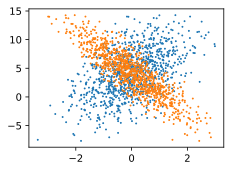

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1);
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

样本的线性关系可以通过散点图展示出来。

## 2.2读取数据集

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)                                   # 按照索引，原地打乱顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  #生成器，每次返回一个batch_size，节省内存

In [6]:
#测试代码
batch_size = 5

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.0825, -0.4166],
        [-0.0309,  0.1480],
        [-1.1989,  0.2801],
        [-0.7098,  1.5855],
        [ 0.1128,  0.4825]]) 
 tensor([[ 3.4500],
        [ 3.6309],
        [ 0.8449],
        [-2.6116],
        [ 2.7840]])


## 2.3初始化模型参数

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
#定义模型
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b #matmul()-矩阵乘法

# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 定义优化算法
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():    #取消更新梯度，减少占用内存
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.1训练
* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [9]:
lr = 0.03             #学习率
num_epochs = 3         #迭代周期
net = linreg
loss = squared_loss

In [10]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000143
epoch 2, loss 0.000049
epoch 3, loss 0.000049


In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0003, 0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([9.1076e-05], grad_fn=<RsubBackward1>)


# 三、线性回归的简洁实现

通过组件来实现

In [12]:
import numpy as np
import torch
from torch.utils import data  #组合样本成 batch，支持多线程、打乱顺序等
from d2l import torch as d2l

In [13]:
# 保持同样的数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

读取数据，我们**调用现有的API读取**

In [14]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) # 每个张量当作独立的位置参数传进去。例如(X ,Y)，相当于拆开后分别传入
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

（**把若干张量快速封装成可迭代的 DataLoader的快捷函数**，省去了自己写 Dataset 和 DataLoader 的模板代码。）

In [15]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [16]:
next(iter(data_iter)) # 我们获取第一项用于检查

[tensor([[-8.6614e-01,  7.6798e-01],
         [ 2.4268e+00, -1.0435e+00],
         [-2.1457e+00, -1.5045e+00],
         [ 3.9482e-01, -1.5884e+00],
         [-5.3396e-01,  2.2382e-01],
         [-1.0155e+00, -2.0293e-03],
         [ 7.0389e-01, -6.3128e-01],
         [ 8.0670e-01, -1.7757e+00],
         [ 4.5848e-01,  1.9091e+00],
         [-6.8029e-01, -9.4972e-01]]),
 tensor([[-0.1417],
         [12.6030],
         [ 5.0192],
         [10.3618],
         [ 2.3552],
         [ 2.1791],
         [ 7.7397],
         [11.8428],
         [-1.3481],
         [ 6.0574]])]

**定义模型**我们首先定义一个模型变量`net`，它是一个`Sequential`类的实例。    
`Sequential`类将多个层串联在一起。当给定输入数据时，`Sequential`实例将数  
据传入到第一层，然后将第一层的输出作为第二层的输入，以此类推。

In [17]:
# nn是神经网络的缩写
from torch import nn
# 全连接层在Linear类中定义
net = nn.Sequential(nn.Linear(2, 1))  #（特征形状1， 特征形状2）：第一个输入，第二个输出

我们通过`net[0]`选择网络中的第一个图层，
然后使用`weight.data`和`bias.data`方法访问参数。
我们还可以使用替换方法`normal_`和`fill_`来重写参数值。

In [18]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [19]:
# 定义损失函数
loss = nn.MSELoss()

# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [20]:
#训练
''' 通过调用`net(X)`生成预测并计算损失`l`（前向传播）。
通过进行反向传播来计算梯度。
通过调用优化器来更新模型参数。'''
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}') # 监控训练过程

epoch 1, loss 0.000179
epoch 2, loss 0.000103
epoch 3, loss 0.000102


In [21]:
#从net访问所需的层，读取权重和偏置
w = net[0].weight.data 
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([8.3804e-05, 1.0324e-04])
b的估计误差： tensor([0.0002])
